In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

In [2]:
datadir = 'input/'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                     index_col = 'device_id')
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

In [3]:
preds = pd.read_csv('logreg_brand_model_train.csv', index_col='device_id')

In [4]:
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

In [5]:
preds.head()

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
-8076087639492063270,0.037475,0.067798,0.041063,0.065220,0.051750,0.039853,0.069456,0.166081,0.107127,0.107441,0.147807,0.098929
-2897161552818060146,0.032803,0.071605,0.041575,0.063344,0.052352,0.038962,0.069328,0.166768,0.106016,0.108658,0.152392,0.096199
-8260683887967679142,0.033982,0.072932,0.037267,0.061902,0.052708,0.039218,0.062273,0.165117,0.109896,0.107058,0.152369,0.105279
-4938849341048082022,0.056571,0.058165,0.041428,0.069147,0.082090,0.067195,0.085281,0.112692,0.071051,0.101413,0.130889,0.124078
245133531816851882,0.066222,0.076016,0.053673,0.061993,0.076234,0.046234,0.123724,0.135783,0.075291,0.097531,0.097494,0.089806


In [6]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
deviceapps.head()

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594.0,NaN
1,-9222956879900151005,1096,18,21594.0,NaN
2,-9222956879900151005,1248,26,21594.0,NaN
3,-9222956879900151005,1545,12,21594.0,NaN
4,-9222956879900151005,1664,18,21594.0,NaN


In [7]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [8]:
Xtr_brandmodel = csr_matrix(preds)

In [9]:
Xtrain = hstack((Xtr_app, Xtr_brandmodel), format='csr')
print('All features: train shape {}'.format(Xtrain.shape))

All features: train shape (74645, 19249)


In [10]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [11]:
def score(clf, random_state = 22):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
        return log_loss(yte, pred[itest, :])
    print('')
    return log_loss(y, pred)

2.30824 2.30018 2.29491 2.29310 2.29583 2.30452 2.32073 2.34471 2.38714 2.43021 

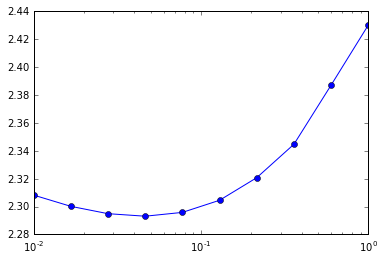

In [13]:
Cs = np.logspace(-2,0,10)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C,multi_class='multinomial',solver='lbfgs')))
plt.semilogx(Cs, res,'-o');